# Having a look to dark images

Looking for correlation on the image 


In [91]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
import pandas as pnd
import glob
import os
import h5py

In [93]:
print_pdf = False

# Import the data 

Generated in the file 3.Analytical-distribution....

In [94]:
data = pnd.read_pickle('data_streak_camera_AM.pkl')
data.head()

,BCT_bunchIntensity,BCT_timeStamp_ms,SCtimeAxis,ScImage,Streak_profile,ScImage_ROI,SCtimeAxis_ROI
141.0,17.3335,1.54116e+12,"[0.0, 2.2154144362622312, 4.4308288725244624, ...","[[423.5166495075018, 410.5592469445674, 427.36...","[72646.4204680449, 73011.62070539195, 72906.84...","[[434.59715513173336, 414.6178102190451, 422.5...","[22.15414436262231, 24.36955879888454, 26.5849..."
142.0,20.1471,1.54116e+12,"[0.0, 2.2154144362622312, 4.4308288725244624, ...","[[425.5368114395019, 426.5214473658121, 420.41...","[73254.84910560814, 73592.20863342653, 74275.0...","[[433.72705493675187, 448.546686758655, 442.49...","[22.15414436262231, 24.36955879888454, 26.5849..."
143.0,20.1362,1.54116e+12,"[0.0, 2.2154144362622312, 4.4308288725244624, ...","[[435.51916974900183, 412.53153006484564, 417....","[73800.51587842796, 73617.80987199066, 73430.4...","[[419.64539974320866, 409.64169228212444, 424....","[22.15414436262231, 24.36955879888454, 26.5849..."
144.0,20.0916,1.54116e+12,"[0.0, 2.2154144362622312, 4.4308288725244624, ...","[[438.56201385450197, 446.47104831259026, 410....","[73231.33886066588, 73424.34368941277, 73363.3...","[[448.6234631661366, 438.5401207844867, 426.52...","[22.15414436262231, 24.36955879888454, 26.5849..."
145.0,19.5409,1.54116e+12,"[0.0, 2.2154144362622312, 4.4308288725244624, ...","[[424.5179096282518, 411.5453885047065, 422.37...","[73547.96853759649, 73168.13777710505, 73673.1...","[[413.6499383453615, 403.65296512571507, 420.5...","[22.15414436262231, 24.36955879888454, 26.5849..."


# Data selection:

- Intensity > 15
- Pixel sum in the ROI > 200e6

In [95]:
flags = data['BCT_bunchIntensity'] < 15
data = data.drop(data.loc[flags].index)

In [96]:
flags = data['ScImage_ROI'].apply(lambda x: np.sum(x)) < 200e6
data = data.drop(data.loc[flags].index)

### CHECK ROUTINE --> PRINTS ALL THE IMAGES
# pixel_sum = []
# for k in range(len(data)):
#     #### IMAGE PLOT
#     im = data['ScImage_ROI'].iloc[k]
    
#     pix_sum = np.sum(data['ScImage_ROI'].iloc[k])
#     pixel_sum.append(pix_sum)
    
#     fig, ax = plt.subplots(1, dpi=200)
#     # image plot
#     ax.imshow(im, clim=(0, 30e3))
#     ax.set_title(pix_sum*1e-6)


# Create two additional profiles for the ROI

In [97]:
# MORE IMAGE PROCESSING
y1 = 280
y2 = 280+80
x1 = 10
x2 = 510
ROI_bounds = (x1,x2,y1,y2)

def get_longitudinal_profile(image, ROI_bounds):
    '''
    Window the image to the ROI and calculate the profile by summing.
    ROI limits are hardcoded.
    '''
    return np.sum(image[ROI_bounds[2]:ROI_bounds[3], ROI_bounds[0]:ROI_bounds[1]], axis=0)

def get_image_in_ROI(image, ROI_bounds):
    '''
    Return the image subset inside the ROI
    '''
    return image[ROI_bounds[2]:ROI_bounds[3], ROI_bounds[0]:ROI_bounds[1]]


data['Streak_profile_top'] = data['ScImage'].apply(lambda x: get_longitudinal_profile(x,ROI_bounds))
data['ScImage_ROI_top'] = data['ScImage'].apply(lambda x: get_image_in_ROI(x,ROI_bounds))
data['SCtimeAxis_ROI_top'] = data['SCtimeAxis'].apply(lambda x: x[ROI_bounds[0]:ROI_bounds[1]])

y1 = y2
y2 = y2+90
x1 = 10
x2 = 510
ROI_bounds = (x1,x2,y1,y2)
data['Streak_profile_bot'] = data['ScImage'].apply(lambda x: get_longitudinal_profile(x,ROI_bounds))
data['ScImage_ROI_bot'] = data['ScImage'].apply(lambda x: get_image_in_ROI(x,ROI_bounds))
data['SCtimeAxis_ROI_bot'] = data['SCtimeAxis'].apply(lambda x: x[ROI_bounds[0]:ROI_bounds[1]])


# FFT the beam data

In [98]:
def doFFT(t, y):
    '''
    Do the FFT. Beware there is a factor 2 in the normalisation, so look at the right-hand side of the spectrum only.
    '''
    assert t.size == y.size, 'Different size in X and Y in the doFFT function'
    dt = np.abs(t[1]-t[0])
    N_sample = t.size
    
    norm = 2/N_sample
    
    s_fft = norm*np.abs(np.fft.fft(y))
    f_fft = np.fft.fftfreq(N_sample, d=dt)
    df = np.abs(f_fft[1]-f_fft[0])
    
    # reorder the fft
    f_fft = np.fft.fftshift(f_fft)
    s_fft = np.fft.fftshift(s_fft)

    return f_fft, s_fft

def dB(x):
    return 20*np.log10(x)

In [99]:
##### DEBUG ROUTINE    
final_length = 2**18
data['SCtimeAxis_ROI_padded'] = [np.empty(0)]*len(data)
data['FFT_freq_ROI'] = [np.empty(0)]*len(data)
data['FFT_mag_ROI'] = [np.empty(0)]*len(data)


for k in range(len(data)):
    # baseline from the tails
    xx = data['SCtimeAxis_ROI'].iloc[k]
    yy = data['Streak_profile'].iloc[k]

    # subset to select tails only
    x1 = xx[:20]
    x2 = xx[-10:]
    xnew = np.concatenate((x1, x2))
    y1 = yy[:20]
    y2 = yy[-10:]
    ynew = np.concatenate((y1, y2))

    # fit baseline 
    param = np.polyfit(xnew, ynew, 1)

    # baseline removed
    yy_no_bline = yy - (xx*param[0] + param[1])

    # zero padding
    assert (final_length > len(xx)) & (np.mod(final_length-len(xx),2) == 0)
    pad_len = final_length - len(xx)
    yy_zero_pad = np.concatenate((np.zeros(int(pad_len/2)), yy_no_bline, np.zeros(int(pad_len/2))))
    dt = xx[1]-xx[0]
    xx = np.concatenate((np.linspace(xx[0]-(pad_len/2)*dt, xx[0]-dt, int(pad_len/2)), xx, np.linspace(xx[-1]+dt, xx[-1]+(pad_len/2)*dt, int(pad_len/2))))
    data['SCtimeAxis_ROI_padded'].iloc[k] = xx

    ####### FFT
    xx = xx*1e-12 # time domain conversion
    

    x_fft, y_fft = doFFT(xx,yy_zero_pad)
    
    data['FFT_freq_ROI'].iloc[k] = x_fft
    data['FFT_mag_ROI'].iloc[k] = y_fft
       


In [100]:
##### DEBUG ROUTINE    
final_length = 2**18
data['FFT_freq_ROI_top'] = [np.empty(0)]*len(data)
data['FFT_mag_ROI_top'] = [np.empty(0)]*len(data)


for k in range(len(data)):
    # baseline from the tails
    xx = data['SCtimeAxis_ROI_top'].iloc[k]
    yy = data['Streak_profile_top'].iloc[k]

    # subset to select tails only
    x1 = xx[:20]
    x2 = xx[-10:]
    xnew = np.concatenate((x1, x2))
    y1 = yy[:20]
    y2 = yy[-10:]
    ynew = np.concatenate((y1, y2))

    # fit baseline 
    param = np.polyfit(xnew, ynew, 1)

    # baseline removed
    yy_no_bline = yy - (xx*param[0] + param[1])

    # zero padding
    assert (final_length > len(xx)) & (np.mod(final_length-len(xx),2) == 0)
    pad_len = final_length - len(xx)
    yy_zero_pad = np.concatenate((np.zeros(int(pad_len/2)), yy_no_bline, np.zeros(int(pad_len/2))))
    dt = xx[1]-xx[0]
    xx = np.concatenate((np.linspace(xx[0]-(pad_len/2)*dt, xx[0]-dt, int(pad_len/2)), xx, np.linspace(xx[-1]+dt, xx[-1]+(pad_len/2)*dt, int(pad_len/2))))


    ####### FFT
    xx = xx*1e-12 # time domain conversion

    x_fft, y_fft = doFFT(xx,yy_zero_pad)
    
    data['FFT_freq_ROI_top'].iloc[k] = x_fft
    data['FFT_mag_ROI_top'].iloc[k] = y_fft
       


In [101]:
##### DEBUG ROUTINE    
final_length = 2**18
data['FFT_freq_ROI_bot'] = [np.empty(0)]*len(data)
data['FFT_mag_ROI_bot'] = [np.empty(0)]*len(data)


for k in range(len(data)):
    # baseline from the tails
    xx = data['SCtimeAxis_ROI_bot'].iloc[k]
    yy = data['Streak_profile_bot'].iloc[k]

    # subset to select tails only
    x1 = xx[:20]
    x2 = xx[-10:]
    xnew = np.concatenate((x1, x2))
    y1 = yy[:20]
    y2 = yy[-10:]
    ynew = np.concatenate((y1, y2))

    # fit baseline 
    param = np.polyfit(xnew, ynew, 1)

    # baseline removed
    yy_no_bline = yy - (xx*param[0] + param[1])

    # zero padding
    assert (final_length > len(xx)) & (np.mod(final_length-len(xx),2) == 0)
    pad_len = final_length - len(xx)
    yy_zero_pad = np.concatenate((np.zeros(int(pad_len/2)), yy_no_bline, np.zeros(int(pad_len/2))))
    dt = xx[1]-xx[0]
    xx = np.concatenate((np.linspace(xx[0]-(pad_len/2)*dt, xx[0]-dt, int(pad_len/2)), xx, np.linspace(xx[-1]+dt, xx[-1]+(pad_len/2)*dt, int(pad_len/2))))


    ####### FFT
    xx = xx*1e-12 # time domain conversion

    x_fft, y_fft = doFFT(xx,yy_zero_pad)
    
    data['FFT_freq_ROI_bot'].iloc[k] = x_fft
    data['FFT_mag_ROI_bot'].iloc[k] = y_fft
       


# Create a second ROI image where there is no beam

In [102]:
# MORE IMAGE PROCESSING
y1 = 450
y2 = 620
x1 = 10
x2 = 510
ROI_bounds = (x1,x2,y1,y2)

def get_longitudinal_profile(image, ROI_bounds):
    '''
    Window the image to the ROI and calculate the profile by summing.
    ROI limits are hardcoded.
    '''
    return np.sum(image[ROI_bounds[2]:ROI_bounds[3], ROI_bounds[0]:ROI_bounds[1]], axis=0)

def get_image_in_ROI(image, ROI_bounds):
    '''
    Return the image subset inside the ROI
    '''
    return image[ROI_bounds[2]:ROI_bounds[3], ROI_bounds[0]:ROI_bounds[1]]


data['Streak_profile_ROI_dark_1'] = data['ScImage'].apply(lambda x: get_longitudinal_profile(x,ROI_bounds))
data['ScImage_ROI_dark_1'] = data['ScImage'].apply(lambda x: get_image_in_ROI(x,ROI_bounds))
data['SCtimeAxis_ROI_dark_1'] = data['SCtimeAxis'].apply(lambda x: x[ROI_bounds[0]:ROI_bounds[1]])


##### FFT STUFF

# sloppy way --> Process 'em all !!
data['FFT_freq_ROI_dark_1'] = [np.empty(0)]*len(data)
data['FFT_mag_ROI_dark_1'] = [np.empty(0)]*len(data)

final_length = 2**18

for k in range(len(data)):
    # baseline from the tails
    xx = data['SCtimeAxis_ROI_dark_1'].iloc[k]
    yy = data['Streak_profile_ROI_dark_1'].iloc[k]

    # subset to select tails only
    x1 = xx[:20]
    x2 = xx[-10:]
    xnew = np.concatenate((x1, x2))
    y1 = yy[:20]
    y2 = yy[-10:]
    ynew = np.concatenate((y1, y2))

    # fit baseline 
    param = np.polyfit(xnew, ynew, 1)

    # baseline removed
    yy_no_bline = yy - (xx*param[0] + param[1])

    # zero padding
    assert (final_length > len(xx)) & (np.mod(final_length-len(xx),2) == 0)
    pad_len = final_length - len(xx)
    yy_zero_pad = np.concatenate((np.zeros(int(pad_len/2)), yy_no_bline, np.zeros(int(pad_len/2))))
    dt = xx[1]-xx[0]
    xx = np.concatenate((np.linspace(xx[0]-(pad_len/2)*dt, xx[0]-dt, int(pad_len/2)), xx, np.linspace(xx[-1]+dt, xx[-1]+(pad_len/2)*dt, int(pad_len/2))))

    ####### FFT
    xx = xx*1e-12 # time domain conversion

    x_fft, y_fft = doFFT(xx,yy_zero_pad)    
    
    data['FFT_freq_ROI_dark_1'].iloc[k] = x_fft
    data['FFT_mag_ROI_dark_1'].iloc[k] = y_fft
   

In [103]:
# MORE IMAGE PROCESSING --> PRODUCE ROI2
y1 = 20
y2 = 220
x1 = 10
x2 = 510
ROI_bounds = (x1,x2,y1,y2)

data['Streak_profile_ROI_dark_2'] = data['ScImage'].apply(lambda x: get_longitudinal_profile(x,ROI_bounds))
data['ScImage_ROI_dark_2'] = data['ScImage'].apply(lambda x: get_image_in_ROI(x,ROI_bounds))
data['SCtimeAxis_ROI_dark_2'] = data['SCtimeAxis'].apply(lambda x: x[ROI_bounds[0]:ROI_bounds[1]])


#### FFT STUFF
# sloppy way --> Process 'em all !!
data['FFT_freq_ROI_dark_2'] = [np.empty(0)]*len(data)
data['FFT_mag_ROI_dark_2'] = [np.empty(0)]*len(data)

final_length = 2**18

for k in range(len(data)):
    # baseline from the tails
    xx = data['SCtimeAxis_ROI_dark_2'].iloc[k]
    yy = data['Streak_profile_ROI_dark_2'].iloc[k]

    # subset to select tails only
    x1 = xx[:100]
    x2 = xx[-100:]
    xnew = np.concatenate((x1, x2))
    y1 = yy[:100]
    y2 = yy[-100:]
    ynew = np.concatenate((y1, y2))

    # fit baseline 
    param = np.polyfit(xnew, ynew, 2)

    # baseline removed
    yy_no_bline = yy - (xx*xx*param[0] + xx*param[1] + param[2])

    # zero padding
    assert (final_length > len(xx)) & (np.mod(final_length-len(xx),2) == 0)
    pad_len = final_length - len(xx)
    yy_zero_pad = np.concatenate((np.zeros(int(pad_len/2)), yy_no_bline, np.zeros(int(pad_len/2))))
    dt = xx[1]-xx[0]
    xx = np.concatenate((np.linspace(xx[0]-(pad_len/2)*dt, xx[0]-dt, int(pad_len/2)), xx, np.linspace(xx[-1]+dt, xx[-1]+(pad_len/2)*dt, int(pad_len/2))))

    ####### FFT
    xx = xx*1e-12 # time domain conversion

    x_fft, y_fft = doFFT(xx,yy_zero_pad)    
    
    data['FFT_freq_ROI_dark_2'].iloc[k] = x_fft
    data['FFT_mag_ROI_dark_2'].iloc[k] = y_fft
   

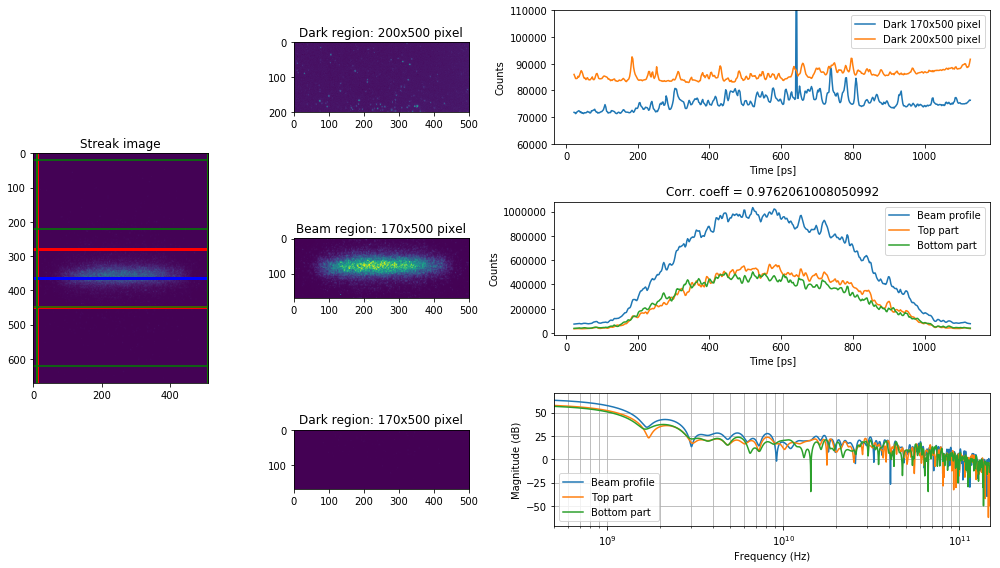

In [104]:
k=90


# test
fig, ax = plt.subplots(3,4, figsize=(14,8))
# subplots arrangement
## kill the first column
gs = ax[0, 0].get_gridspec()
for a in ax[0:, 0]: # remove the underlying axes
    a.remove()
## create a single big axis for the figure
im_ax = fig.add_subplot(gs[0:, 0])
## kill the top right plots
gs2 = ax[0, -2].get_gridspec()
# remove the underlying axes
ax[0, -2].remove()
ax[0, -1].remove()
## create a single big axis for the profile
dark_ax = fig.add_subplot(gs2[0, 2:])
## kill the top right plots
gs3 = ax[1, -2].get_gridspec()
# remove the underlying axes
ax[1, -2].remove()
ax[1, -1].remove()
## create a single big axis for the profile
prof_ax = fig.add_subplot(gs3[1, 2:])


## kill the top right plots
gs4 = ax[1, -2].get_gridspec()
# remove the underlying axes
ax[2, -2].remove()
ax[2, -1].remove()
## create a single big axis for the profile
fft_ax = fig.add_subplot(gs4[2, 2:])



# full img
im_ax.imshow(data['ScImage'].iloc[k])
im_ax.set_title('Streak image')
#boundaries idx
y1 = 280
y2 = 450
x1 = 10
x2 = 510 
im_ax.axvline(x = x1, color='r',linewidth=3)
im_ax.axvline(x = x2, color='r',linewidth=3)
im_ax.axhline(y = y1, color='r',linewidth=3)
im_ax.axhline(y = y2, color='r',linewidth=3)
im_ax.axhline(y = y1+85, color='b',linewidth=3)


y1 = 20
y2 = 220
im_ax.axvline(x = x1, color='g')
im_ax.axvline(x = x2, color='g')
im_ax.axhline(y = y1, color='g')
im_ax.axhline(y = y2, color='g')

y1 = 450
y2 = 620
im_ax.axvline(x = x1, color='g')
im_ax.axvline(x = x2, color='g')
im_ax.axhline(y = y1, color='g')
im_ax.axhline(y = y2, color='g')


#image cuts plot
ax[0,1].imshow(data['ScImage_ROI_dark_2'].iloc[k])
ax[0,1].set_title('Dark region: 200x500 pixel')
ax[1,1].imshow(data['ScImage_ROI'].iloc[k])
ax[1,1].set_title('Beam region: 170x500 pixel')
ax[2,1].imshow(data['ScImage_ROI_dark_1'].iloc[k])
ax[2,1].set_title('Dark region: 170x500 pixel')


#profile
prof_ax.plot(data['SCtimeAxis_ROI'].iloc[k], data['Streak_profile'].iloc[k],label='Beam profile')
prof_ax.plot(data['SCtimeAxis_ROI_top'].iloc[k], data['Streak_profile_top'].iloc[k],label='Top part')
prof_ax.plot(data['SCtimeAxis_ROI_bot'].iloc[k], data['Streak_profile_bot'].iloc[k],label='Bottom part')

corr = np.corrcoef([data['Streak_profile_top'].iloc[k], data['Streak_profile_bot'].iloc[k]])[0,1]
prof_ax.set_title('Corr. coeff = '+str(corr))

prof_ax.legend(frameon=True)
prof_ax.set_xlabel('Time [ps]')
prof_ax.set_ylabel('Counts')

#dark profile plot
dark_ax.plot(data['SCtimeAxis_ROI_dark_1'].iloc[k], data['Streak_profile_ROI_dark_1'].iloc[k],label='Dark 170x500 pixel')
dark_ax.plot(data['SCtimeAxis_ROI_dark_2'].iloc[k], data['Streak_profile_ROI_dark_2'].iloc[k],label='Dark 200x500 pixel')
dark_ax.legend(frameon=True)
dark_ax.set_xlabel('Time [ps]')
dark_ax.set_ylabel('Counts')
dark_ax.set_ylim(60e3, 110e3)

#FFT
fft_ax.plot(data['FFT_freq_ROI'].iloc[k], dB(data['FFT_mag_ROI'].iloc[k]),label='Beam profile')
fft_ax.plot(data['FFT_freq_ROI_top'].iloc[k], dB(data['FFT_mag_ROI_top'].iloc[k]),label='Top part')
fft_ax.plot(data['FFT_freq_ROI_bot'].iloc[k], dB(data['FFT_mag_ROI_bot'].iloc[k]),label='Bottom part')

fft_ax.set_xlim(5e8, 150e9)
# fft_ax.set_ylim(-120,)
fft_ax.set_xscale('log')
fft_ax.grid(which='both')
fft_ax.set_ylabel('Magnitude (dB)')
fft_ax.set_xlabel('Frequency (Hz)')
fft_ax.legend(frameon=True)

plt.tight_layout()

In [105]:
from scipy import fftpack

def apply_bandpass_filter(freqs, f_spectrum, flow, fhi):
    ss = f_spectrum.copy()
    bool_idx =  np.logical_or(np.logical_and(freqs>flow, freqs<fhi), np.logical_and(freqs<-flow, freqs>-fhi))
    ss[~bool_idx] = 0.
    return ss

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


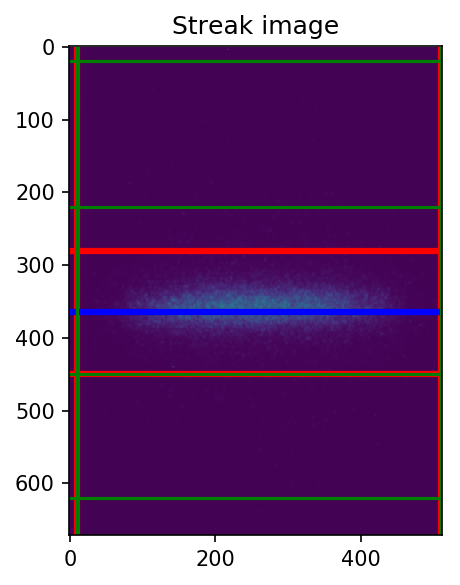

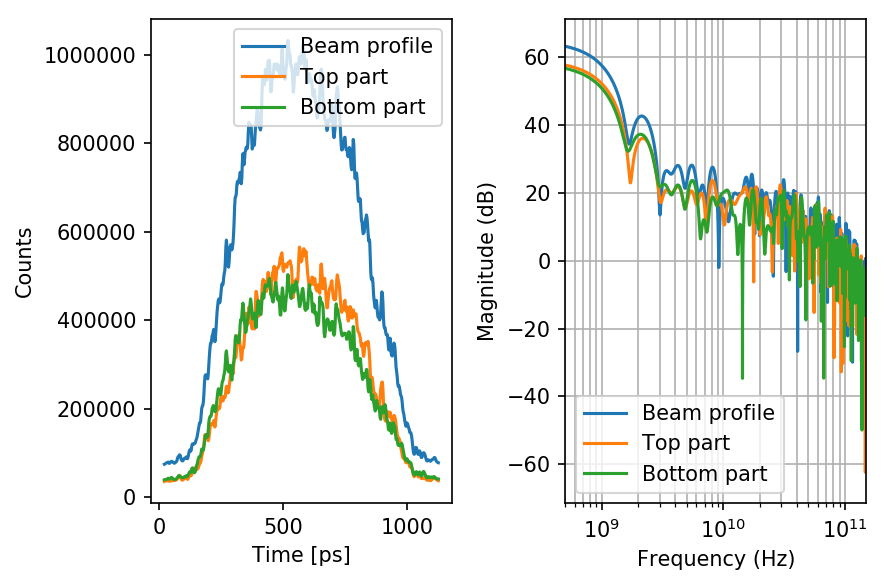

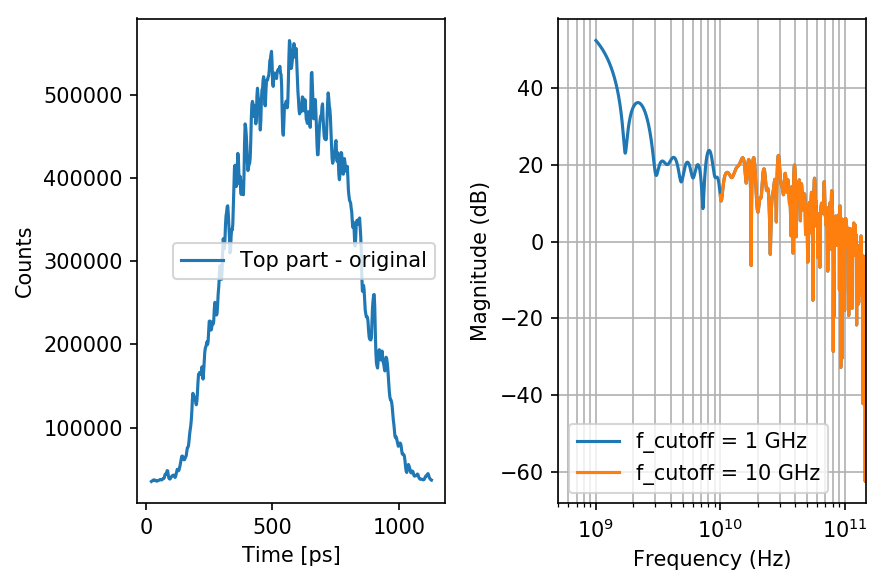

In [106]:
k=90

# full image
fig1, im_ax = plt.subplots(1, dpi=150)

im_ax.imshow(data['ScImage'].iloc[k])
im_ax.set_title('Streak image')
#boundaries idx
y1 = 280
y2 = 450
x1 = 10
x2 = 510 
im_ax.axvline(x = x1, color='r',linewidth=3)
im_ax.axvline(x = x2, color='r',linewidth=3)
im_ax.axhline(y = y1, color='r',linewidth=3)
im_ax.axhline(y = y2, color='r',linewidth=3)
im_ax.axhline(y = y1+85, color='b',linewidth=3)


y1 = 20
y2 = 220
im_ax.axvline(x = x1, color='g')
im_ax.axvline(x = x2, color='g')
im_ax.axhline(y = y1, color='g')
im_ax.axhline(y = y2, color='g')

y1 = 450
y2 = 620
im_ax.axvline(x = x1, color='g')
im_ax.axvline(x = x2, color='g')
im_ax.axhline(y = y1, color='g')
im_ax.axhline(y = y2, color='g')


#image cuts plot
ax[0,1].imshow(data['ScImage_ROI_dark_2'].iloc[k])
ax[0,1].set_title('Dark region: 200x500 pixel')
ax[1,1].imshow(data['ScImage_ROI'].iloc[k])
ax[1,1].set_title('Beam region: 170x500 pixel')
ax[2,1].imshow(data['ScImage_ROI_dark_1'].iloc[k])
ax[2,1].set_title('Dark region: 170x500 pixel')
plt.tight_layout()


# profile plot pre-filter
fig2, prof_ax = plt.subplots(1, 2, dpi=150)
prof_ax[0].plot(data['SCtimeAxis_ROI'].iloc[k], data['Streak_profile'].iloc[k],label='Beam profile')
prof_ax[0].plot(data['SCtimeAxis_ROI_top'].iloc[k], data['Streak_profile_top'].iloc[k],label='Top part')
prof_ax[0].plot(data['SCtimeAxis_ROI_bot'].iloc[k], data['Streak_profile_bot'].iloc[k],label='Bottom part')

corr = np.corrcoef([data['Streak_profile_top'].iloc[k], data['Streak_profile_bot'].iloc[k]])[0,1]
# prof_ax[0].set_title('Corr. coeff = '+str(corr))

prof_ax[0].legend(frameon=True)
prof_ax[0].set_xlabel('Time [ps]')
prof_ax[0].set_ylabel('Counts')

# FFT
prof_ax[1].plot(data['FFT_freq_ROI'].iloc[k], dB(data['FFT_mag_ROI'].iloc[k]),label='Beam profile')
prof_ax[1].plot(data['FFT_freq_ROI_top'].iloc[k], dB(data['FFT_mag_ROI_top'].iloc[k]),label='Top part')
prof_ax[1].plot(data['FFT_freq_ROI_bot'].iloc[k], dB(data['FFT_mag_ROI_bot'].iloc[k]),label='Bottom part')

prof_ax[1].set_xlim(5e8, 150e9)
# fft_ax.set_ylim(-120,)
prof_ax[1].set_xscale('log')
prof_ax[1].grid(which='both')
prof_ax[1].set_ylabel('Magnitude (dB)')
prof_ax[1].set_xlabel('Frequency (Hz)')
prof_ax[1].legend(frameon=True)

plt.tight_layout()


###################### Ok now let's start filtering 
fig3, filt_ax = plt.subplots(1, 2, dpi=150)
xx = data['SCtimeAxis_ROI_top'].iloc[k]
yy = data['Streak_profile_top'].iloc[k]
filt_ax[0].plot(xx, yy,label='Top part - original')
filt_ax[0].legend(frameon=True)
filt_ax[0].set_xlabel('Time [ps]')
filt_ax[0].set_ylabel('Counts')

# hard window filter
ff_filt = apply_bandpass_filter(data['FFT_freq_ROI_top'].iloc[k], data['FFT_mag_ROI_top'].iloc[k], 1e9, np.max(data['FFT_freq_ROI_top'].iloc[k]))
yy_filt = fftpack.ifft(ff_filt)
filt_ax[1].plot(data['FFT_freq_ROI_top'].iloc[k], dB(ff_filt),label='f_cutoff = 1 GHz')

ff_filt = apply_bandpass_filter(data['FFT_freq_ROI_top'].iloc[k], data['FFT_mag_ROI_top'].iloc[k], 10e9, np.max(data['FFT_freq_ROI_top'].iloc[k]))
yy_filt = fftpack.ifft(ff_filt)
filt_ax[1].plot(data['FFT_freq_ROI_top'].iloc[k], dB(ff_filt),label='f_cutoff = 10 GHz')

filt_ax[1].set_xlim(5e8, 150e9)
filt_ax[1].set_xscale('log')
filt_ax[1].grid(which='both')
filt_ax[1].set_ylabel('Magnitude (dB)')
filt_ax[1].set_xlabel('Frequency (Hz)')
filt_ax[1].legend(frameon=True)

# hard window filter



plt.tight_layout()




/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


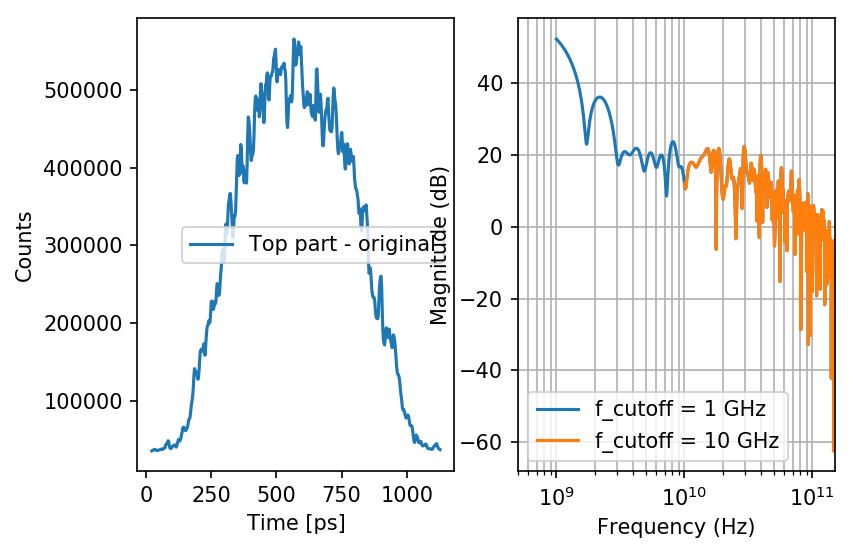

In [107]:
###################### Ok now let's start filtering 
fig3, filt_ax = plt.subplots(1, 2, dpi=150)
xx = data['SCtimeAxis_ROI_top'].iloc[k]
yy = data['Streak_profile_top'].iloc[k]
filt_ax[0].plot(xx, yy,label='Top part - original')
filt_ax[0].legend(frameon=True)
filt_ax[0].set_xlabel('Time [ps]')
filt_ax[0].set_ylabel('Counts')

# hard window filter
ff_filt = apply_bandpass_filter(data['FFT_freq_ROI_top'].iloc[k], data['FFT_mag_ROI_top'].iloc[k], 1e9, np.max(data['FFT_freq_ROI_top'].iloc[k]))
yy_filt = fftpack.ifft(ff_filt)
filt_ax[1].plot(data['FFT_freq_ROI_top'].iloc[k], dB(ff_filt),label='f_cutoff = 1 GHz')

ff_filt = apply_bandpass_filter(data['FFT_freq_ROI_top'].iloc[k], data['FFT_mag_ROI_top'].iloc[k], 10e9, np.max(data['FFT_freq_ROI_top'].iloc[k]))
yy_filt = fftpack.ifft(ff_filt)
filt_ax[1].plot(data['FFT_freq_ROI_top'].iloc[k], dB(ff_filt),label='f_cutoff = 10 GHz')

filt_ax[1].set_xlim(5e8, 150e9)
filt_ax[1].set_xscale('log')
filt_ax[1].grid(which='both')
filt_ax[1].set_ylabel('Magnitude (dB)')
filt_ax[1].set_xlabel('Frequency (Hz)')
filt_ax[1].legend(frameon=True)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
No handles with labels found to put in legend.


(-20, 65.465003831918)

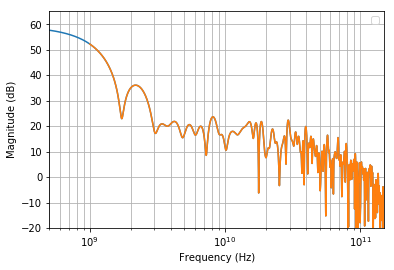

In [108]:
plt.plot(data['FFT_freq_ROI_top'].iloc[k], dB(data['FFT_mag_ROI_top'].iloc[k]))
ff_filt = apply_bandpass_filter(data['FFT_freq_ROI_top'].iloc[k], data['FFT_mag_ROI_top'].iloc[k], 1e9, np.max(data['FFT_freq_ROI_top'].iloc[k]))

plt.plot(data['FFT_freq_ROI_top'].iloc[k], dB(ff_filt))
plt.xlim(5e8, 150e9)
plt.xscale('log')
plt.grid(which='both')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.legend(frameon=True)
plt.ylim(-20,)

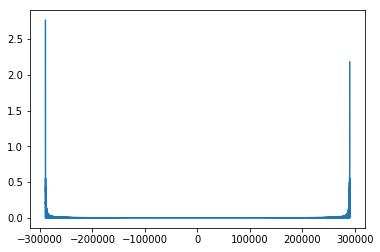

In [110]:
plt.plot(data['SCtimeAxis_ROI_padded'].iloc[k], np.abs(fftpack.ifft(ff_filt)))

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
pdf_report = PdfPages('streak_camera_full_halfs_even.pdf')

for k in range(len(data)):
    fig, ax = plt.subplots(3,4, figsize=(14,8))
    # subplots arrangement
    ## kill the first column
    gs = ax[0, 0].get_gridspec()
    for a in ax[0:, 0]: # remove the underlying axes
        a.remove()
    ## create a single big axis for the figure
    im_ax = fig.add_subplot(gs[0:, 0])
    ## kill the top right plots
    gs2 = ax[0, -2].get_gridspec()
    # remove the underlying axes
    ax[0, -2].remove()
    ax[0, -1].remove()
    ## create a single big axis for the profile
    dark_ax = fig.add_subplot(gs2[0, 2:])
    ## kill the top right plots
    gs3 = ax[1, -2].get_gridspec()
    # remove the underlying axes
    ax[1, -2].remove()
    ax[1, -1].remove()
    ## create a single big axis for the profile
    prof_ax = fig.add_subplot(gs3[1, 2:])


    ## kill the top right plots
    gs4 = ax[1, -2].get_gridspec()
    # remove the underlying axes
    ax[2, -2].remove()
    ax[2, -1].remove()
    ## create a single big axis for the profile
    fft_ax = fig.add_subplot(gs4[2, 2:])



    # full img
    im_ax.imshow(data['ScImage'].iloc[k])
    im_ax.set_title('Streak image')
    #boundaries idx
    y1 = 280
    y2 = 450
    x1 = 10
    x2 = 510 
    im_ax.axvline(x = x1, color='r',linewidth=3)
    im_ax.axvline(x = x2, color='r',linewidth=3)
    im_ax.axhline(y = y1, color='r',linewidth=3)
    im_ax.axhline(y = y2, color='r',linewidth=3)

    y1 = 20
    y2 = 220
    im_ax.axvline(x = x1, color='g')
    im_ax.axvline(x = x2, color='g')
    im_ax.axhline(y = y1, color='g')
    im_ax.axhline(y = y2, color='g')

    y1 = 450
    y2 = 620
    im_ax.axvline(x = x1, color='g')
    im_ax.axvline(x = x2, color='g')
    im_ax.axhline(y = y1, color='g')
    im_ax.axhline(y = y2, color='g')


    #image cuts plot
    ax[0,1].imshow(data['ScImage_ROI_dark_2'].iloc[k])
    ax[0,1].set_title('Dark region: 200x500 pixel')
    ax[1,1].imshow(data['ScImage_ROI'].iloc[k])
    ax[1,1].set_title('Beam region: 170x500 pixel')
    ax[2,1].imshow(data['ScImage_ROI_dark_1'].iloc[k])
    ax[2,1].set_title('Dark region: 170x500 pixel')


    #profile
    prof_ax.plot(data['SCtimeAxis_ROI'].iloc[k], data['Streak_profile'].iloc[k],label='Beam profile')
    prof_ax.plot(data['SCtimeAxis_ROI_top'].iloc[k], data['Streak_profile_top'].iloc[k],label='Top part')
    prof_ax.plot(data['SCtimeAxis_ROI_bot'].iloc[k], data['Streak_profile_bot'].iloc[k],label='Bottom part')

    corr = np.corrcoef([data['Streak_profile_top'].iloc[k], data['Streak_profile_bot'].iloc[k]])[0,1]
    prof_ax.set_title('Corr. coeff = '+str(corr))

    prof_ax.legend(frameon=True)
    prof_ax.set_xlabel('Time [ps]')
    prof_ax.set_ylabel('Counts')

    #dark profile plot
    dark_ax.plot(data['SCtimeAxis_ROI_dark_1'].iloc[k], data['Streak_profile_ROI_dark_1'].iloc[k],label='Dark 170x500 pixel')
    dark_ax.plot(data['SCtimeAxis_ROI_dark_2'].iloc[k], data['Streak_profile_ROI_dark_2'].iloc[k],label='Dark 200x500 pixel')
    dark_ax.legend(frameon=True)
    dark_ax.set_xlabel('Time [ps]')
    dark_ax.set_ylabel('Counts')
    dark_ax.set_ylim(60e3, 110e3)

    #FFT
    fft_ax.plot(data['FFT_freq_ROI'].iloc[k], dB(data['FFT_mag_ROI'].iloc[k]),label='Beam profile')
    fft_ax.plot(data['FFT_freq_ROI_dark_1'].iloc[k], dB(data['FFT_mag_ROI_dark_1'].iloc[k]),label='Dark 170x500 pixel')
    fft_ax.plot(data['FFT_freq_ROI_dark_2'].iloc[k], dB(data['FFT_mag_ROI_dark_2'].iloc[k]),label='Dark 200x500 pixel')

    fft_ax.set_xlim(5e8, 150e9)
    # fft_ax.set_ylim(-120,)
    fft_ax.set_xscale('log')
    fft_ax.grid(which='both')
    fft_ax.set_ylabel('Magnitude (dB)')
    fft_ax.set_xlabel('Frequency (Hz)')
    fft_ax.legend(frameon=True)

    plt.tight_layout()
    
    ### ADD PDF PAGE
    if np.mod(k,10):
        print(k)
    pdf_report.savefig(fig, orientation='landscape')
    del(fig)

pdf_report.close()